## **1. Instructions**

**MultiModal RAG App for Video Processing With LlamaIndex and LanceDB**

1. llamaindex framework

2. Lancedb Vector DataBase
   
3. LLM MultiModAl GPT-4V or Google-gemini-pro-vision


**Steps Need to follow:**
1. Download video from YouTube, process and store it.

2. Build Multi-Modal index and vector store for both texts and images.

3. Retrieve relevant images and context, use both to augment the prompt.

4. Using GPT4V for reasoning the correlations between the input query and augmented data and generating final response.

## **2. IMPORT AND INSTALL**

### Vector DB libraries

In [1]:
# %pip install llama-index-vector-stores-lancedb
# %pip install llama-index-multi-modal-llms-openai
# %pip install llama-index-embeddings-clip
# %pip install git+https://github.com/openai/CLIP.git
# !pip install llama-index-readers-file

In [2]:
# %pip install llama_index
# %pip install -U openai-whisper

### Video Libraries

In [3]:
# %pip install lancedb
# %pip install moviepy
# %pip install pytube
# %pip install pydub
# %pip install SpeechRecognition
# %pip install ffmpeg-python
# %pip install soundfile
# %pip install torch torchvision
# %pip install matplotlib scikit-image
# %pip install ftfy regex tqdm

1. ffmpeg-library enables you to use FFmpeg in Python to manipulate various media files for different purposes like building comprehensive multimedia applications, preprocessing media files.

2. MoviePy is a Python library for video editing, enabling cutting, concatenations, title insertions, video compositing, and effects like animations or color grading.

3. Pytube is a Python library used for downloading videos from YouTube. It supports downloading in various formats, resolutions, and also direct audio extraction.

4. Pydub is a Python library for audio manipulation, enabling easy loading,
editing, and exporting of audio files in various formats with minimal code.

5. The SpeechRecognition library in Python allows you to convert spoken language into text using various engines and APIs, such as Google Speech Recognition, IBM Speech to Text, etc.

6. SoundFile is a Python library for reading from and writing to audio files, supporting many formats through the libsndfile library, ideal for high-quality audio processing.

7. FTFY (Fix Text For You) is a Python library that fixes broken Unicode text and mojibake (garbled text due to encoding issues), making text legible again.

8. OpenAI Whisper is a robust, multilingual speech recognition model developed by OpenAI. It converts speech into text and supports various languages with high accuracy.

9. pprint is a Python module that provides a capability to "pretty-print" complex data structures in a well-formatted and more readable way than the basic print function.

In [25]:
import moviepy
import os
from moviepy import VideoFileClip
from pathlib import Path
import speech_recognition as sr
from pytube import YouTube
from pprint import pprint
from PIL import Image
import matplotlib.pyplot as plt
import yt_dlp
import os
import dotenv
import json
from llama_index.multi_modal_llms.openai import OpenAIMultiModal

dotenv.load_dotenv()
OPENAI_API_TOKEN = os.getenv("OPENAI_API_KEY")
print(f"OPENAI_API_TOKEN: {OPENAI_API_TOKEN[0:10]}...")
os.environ["OPENAI_API_KEY"] = OPENAI_API_TOKEN
# print(moviepy.__file__)
absolute_path = os.getcwd()
print(absolute_path)

OPENAI_API_TOKEN: sk-proj-Bs...
d:\Coursera Courses (NVME)\MultiModal RAG\MultiModal-RAG-Generative-AI-Indepth-Basic-to-Advance\MultiModal RAG


## **3. Extract images, audio and text from video**

### 1. Paths and Folder

In [5]:
video_url="https://youtu.be/3dhcmeOTZ_Q"
# video_url="https://www.youtube.com/watch?v=pvrioGzF-6s&list=PLQxDHpeGU14D6dm0rmAXhdLeLYlX2zk7p&index=3&ab_channel=SunnySavita"

output_video_path = absolute_path + "\\content\\video_data\\"

# from the video i am going to collect images,audio,text
output_folder = absolute_path + "\\content\\mixed_data\\"
output_audio_path = absolute_path + "\\content\\mixed_data\\output_audio.wav"

# !mkdir mixed_data

filepath = output_video_path #+ "input_vid.mp4"
print(f"filepath : {filepath}")
print(f"video_url : {video_url}")
print(f"output_video_path : {output_video_path}")
print(f"output_audio_path : {output_audio_path}")


filepath : d:\Coursera Courses (NVME)\MultiModal RAG\MultiModal-RAG-Generative-AI-Indepth-Basic-to-Advance\MultiModal RAG\content\video_data\
video_url : https://youtu.be/3dhcmeOTZ_Q
output_video_path : d:\Coursera Courses (NVME)\MultiModal RAG\MultiModal-RAG-Generative-AI-Indepth-Basic-to-Advance\MultiModal RAG\content\video_data\
output_audio_path : d:\Coursera Courses (NVME)\MultiModal RAG\MultiModal-RAG-Generative-AI-Indepth-Basic-to-Advance\MultiModal RAG\content\mixed_data\output_audio.wav


### 2. download_video

In [6]:
# Download the video from YouTube
def download_video(url, output_path):
    ydl_opts = {
        'outtmpl': f'{output_path}/input_vid.%(ext)s',
        'format': 'bestvideo+bestaudio/best',
    }

    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info_dict = ydl.extract_info(url, download=True)
        downloaded_path = ydl.prepare_filename(info_dict)
        metadata = {
            "Author": info_dict.get("uploader"),
            "Title": info_dict.get("title"),
            "Views": info_dict.get("view_count"),
            "FilePath": downloaded_path,

        }

    return metadata

metadata_vid = download_video(video_url, output_video_path)
video_filepath = metadata_vid["FilePath"]
print(f"Video downloaded to: \n{video_filepath}")

[youtube] Extracting URL: https://youtu.be/3dhcmeOTZ_Q
[youtube] 3dhcmeOTZ_Q: Downloading webpage
[youtube] 3dhcmeOTZ_Q: Downloading tv client config
[youtube] 3dhcmeOTZ_Q: Downloading tv player API JSON
[youtube] 3dhcmeOTZ_Q: Downloading ios player API JSON
[youtube] 3dhcmeOTZ_Q: Downloading m3u8 information
[info] 3dhcmeOTZ_Q: Downloading 1 format(s): 303+251
[download] d:\Coursera Courses (NVME)\MultiModal RAG\MultiModal-RAG-Generative-AI-Indepth-Basic-to-Advance\MultiModal RAG\content\video_data\input_vid.webm has already been downloaded
Video downloaded to: 
d:\Coursera Courses (NVME)\MultiModal RAG\MultiModal-RAG-Generative-AI-Indepth-Basic-to-Advance\MultiModal RAG\content\video_data\input_vid.webm


### 3. video_to_images

In [7]:
# Download the video
def video_to_images(video_path,output_folder):
  clip = VideoFileClip(video_path)
  clip.write_images_sequence(
      os.path.join(output_folder,"frame%04d.png"),
      fps = 0.2
  )

video_to_images(video_filepath , output_folder)

### 4. video_to_audio

In [8]:
# Download the video
def video_to_audio(video_path,output_audio_path):
  clip = VideoFileClip(video_path)
  audio = clip.audio
  audio.write_audiofile(output_audio_path)
 
video_to_audio(video_filepath , output_audio_path)

MoviePy - Writing audio in d:\Coursera Courses (NVME)\MultiModal RAG\MultiModal-RAG-Generative-AI-Indepth-Basic-to-Advance\MultiModal RAG\content\mixed_data\output_audio.wav


MoviePy - Done.


### 5. audio_to_text

In [9]:
# Function to extract audio from a video file and convert it to text using Whisper
def audio_to_text(audio_path):
  recognizer = sr.Recognizer()
  audio = sr.AudioFile(audio_path)

  with audio as source:
    audio_data = recognizer.record(source)

    try:
      #recognize the speech
      text = recognizer.recognize_whisper(audio_data)

    except sr.UnknownValueError:
      print("Speech recognition could not understand the audio.")
  return text

text_data=audio_to_text(output_audio_path)
print(f"Extracted Text: {text_data}")



Extracted Text:  Lennie regression is a statistical technique for modeling the relationship between an output variable and one or more input variables. In layman's terms, think of it as fitting a line through some data points as shown here, so you can make predictions on unknown data, assuming there is a linear relationship between the variables. You might be familiar with the linear function y equals mx plus b, where y is the output variable, also called the dependent variable. You may also see expressed as f of x, the function of the input variable. x on the other hand, would serve as the input variable, also called the independent variable. It's likely you'll see the coefficients m and b expressed as beta 1 and beta 0 respectively. So what do the m and b coefficients do? The m or beta 1 coefficient controls the slope of the line, the b or the beta 0 controls the intercept of the line, in machine learning we also know it as the bias. These two coefficients are what we are solving for

### 6. Write data file

In [10]:
# write the text data to a file
with open(output_folder + "output_text.txt", "w") as file:
        file.write(text_data)
print("Text data saved to file")
file.close()

Text data saved to file


In [11]:
os.remove(output_audio_path)
print("Audio file removed")

Audio file removed


In [12]:
#process the video
#image
#text

## **4. Vector DB**

### 1. Indexing

In [13]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core import SimpleDirectoryReader
from llama_index.core import StorageContext
from llama_index.vector_stores.lancedb import LanceDBVectorStore

from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

In [ ]:
# 📦 1. Create Vector Stores for Text and Images
text_store =  LanceDBVectorStore(uri="lancedb" , table_name="text_collection")
image_store = LanceDBVectorStore(uri="lancedb" , table_name="image_collection")

# 🧠 2. Create a Unified Storage Context
storage_context = StorageContext.from_defaults(vector_store=text_store,image_store=image_store)

# 📂 3. Load Documents
documents = SimpleDirectoryReader(output_folder).load_data()

# 📇 4. Create a MultiModal Index
index = MultiModalVectorStoreIndex.from_documents(documents,storage_context=storage_context)

# 🔍 5. Create a Retriever Engine
retriever_engine = index.as_retriever(similarity_top_k=1, image_similarity_top_k=5)


### 2. Retriever

In [15]:
def retrieve(retriever_engine, query_str):
    retrieval_results = retriever_engine.retrieve(query_str)

    retrieved_image = []
    retrieved_text = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=2000)
            retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text

In [16]:
query = "can you tell me what is linear regression? explain equation of the multiple linear regression?"

### 3. Query

In [17]:
img , text = retrieve(retriever_engine , query)
img

**Node ID:** 702e38b0-40d0-4f10-83ab-58048b34fc2b<br>**Similarity:** 0.7461580038070679<br>**Text:** Lennie regression is a statistical technique for modeling the relationship between an output variable and one or more input variables. In layman's terms, think of it as fitting a line through some data points as shown here, so you can make predictions on unknown data, assuming there is a linear relationship between the variables. You might be familiar with the linear function y equals mx plus b, where y is the output variable, also called the dependent variable. You may also see expressed as f of x, the function of the input variable. x on the other hand, would serve as the input variable, also called the independent variable. It's likely you'll see the coefficients m and b expressed as beta 1 and beta 0 respectively. So what do the m and b coefficients do? The m or beta 1 coefficient controls the slope of the line, the b or the beta 0 controls the intercept of the line, in machine learning we also know it as the bias. These two coefficients are what we are solving for in linear regression. We can also extend to multiple input variables, so x1, x2, x3, with beta 1, beta 2, and beta 3, and so on, acting as slopes for each of those variables. In these higher dimensions, you would visualize the linear regression as a hyperplane. So how do we fit the line to these points? Well you'll notice that there's these differences between the points and the line, these little red segments, these are called residuals. They are the differences between the data points and the predictions the line would produce. Take each of these residuals and square them. These are the squared errors, and notice that the large of the residuals are, the more amplified area of the squares are. If we total the areas of all of these squares for a given line, we will get the sum of the squared error, and this is known as our loss function. We need to find the beta 0 and beta 1 coefficients that will minimize that sum of squared error. The coefficients can be solved with a variety of techniques rangin...<br>

['d:\\Coursera Courses (NVME)\\MultiModal RAG\\MultiModal-RAG-Generative-AI-Indepth-Basic-to-Advance\\MultiModal RAG\\content\\mixed_data\\frame0003.png',
 'd:\\Coursera Courses (NVME)\\MultiModal RAG\\MultiModal-RAG-Generative-AI-Indepth-Basic-to-Advance\\MultiModal RAG\\content\\mixed_data\\frame0028.png',
 'd:\\Coursera Courses (NVME)\\MultiModal RAG\\MultiModal-RAG-Generative-AI-Indepth-Basic-to-Advance\\MultiModal RAG\\content\\mixed_data\\frame0042.png']

In [18]:
import matplotlib.pyplot as plt
def plot_images(images_path):
  images_shown = 0
  plt.figure(figsize=(16, 9))
  for img_path in images_path:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 5:
                break

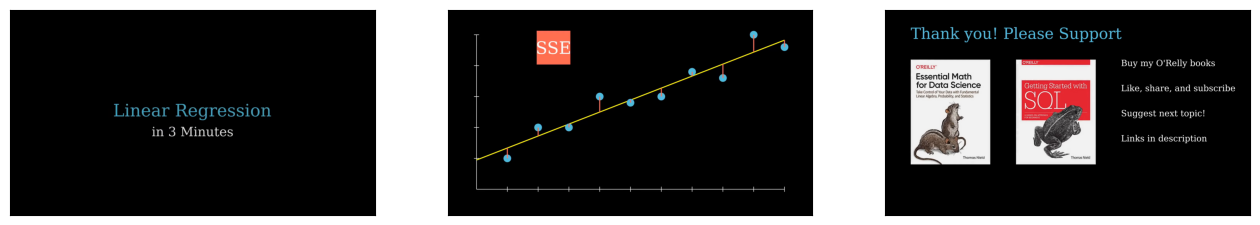

In [19]:
plot_images(img)

In [32]:
image_documents = SimpleDirectoryReader( input_files = img).load_data()
image_documents

[ImageDocument(id_='993e1482-2b01-44cf-b5af-9d282b9470d8', embedding=None, metadata={'file_path': 'd:\\Coursera Courses (NVME)\\MultiModal RAG\\MultiModal-RAG-Generative-AI-Indepth-Basic-to-Advance\\MultiModal RAG\\content\\mixed_data\\frame0003.png', 'file_name': 'frame0003.png', 'file_type': 'image/png', 'file_size': 93670, 'creation_date': '2025-07-23', 'last_modified_date': '2025-07-23'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=None, image_resource=MediaResource(embeddings=None, data=None, text=None, path=WindowsPath('d:/Coursera Courses (NVME)/MultiModal RAG/MultiModal-RAG-Generative-AI-Indepth-Basic-to-Advance/MultiModal RAG/content/mixed_data/frame0003.png'), url=None, mi

### 4. RAG Prompt with LLM

In [41]:
metadata_str = json.dumps(metadata_vid)
query_str = "can you tell me what is linear regression and equation of linear regression?"
context_str = "".join(text)

# system template prompt
qa_tmpl_str = (
    "Based on the provided information, including relevant images and retrieved context from the video, \
    accurately and precisely answer the query without any additional prior knowledge.\n"

    "---------------------\n"
    "Context: {context_str}\n"
    "Metadata for video: {metadata_str} \n"

    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)

# prompt 
prompt = qa_tmpl_str.format(
    query_str = query_str,
    metadata_str = metadata_str,
    context_str=context_str)

# llm
openai_mm_llm = OpenAIMultiModal(model="gpt-4o", api_key=OPENAI_API_TOKEN, max_new_tokens=1500)

C:\Users\ZAIN\AppData\Local\Temp\ipykernel_19716\3686214337.py:26: DeprecationWarning: Call to deprecated class OpenAIMultiModal. (The package has been deprecated and will no longer be maintained. Please use llama-index-llms-openai (preferably the Responses API) instead. See Multi Modal LLMs documentation for a complete guide on migration: https://docs.llamaindex.ai/en/stable/understanding/using_llms/using_llms/#multi-modal-llms) -- Deprecated since version 0.5.2.
  openai_mm_llm = OpenAIMultiModal(model="gpt-4o", api_key=OPENAI_API_TOKEN, max_new_tokens=1500)


In [42]:
from llama_index.core.schema import ImageNode

image_nodes = [
    ImageNode(image_path=doc.metadata["file_path"])  # or `image=...` depending on version
    for doc in image_documents
]

result = openai_mm_llm.complete(
    prompt=prompt,
    image_documents=image_nodes,
)


In [43]:
pprint(result.text)

('Linear regression is a statistical technique used to model the relationship '
 'between an output variable (dependent variable) and one or more input '
 'variables (independent variables). It involves fitting a line through data '
 'points to make predictions, assuming a linear relationship between the '
 'variables.\n'
 '\n'
 'The equation for linear regression is:\n'
 '\n'
 '\\[ y = mx + b \\]\n'
 '\n'
 'Where:\n'
 '- \\( y \\) is the output (dependent variable).\n'
 '- \\( x \\) is the input (independent variable).\n'
 '- \\( m \\) (or \\(\\beta_1\\)) is the slope of the line.\n'
 '- \\( b \\) (or \\(\\beta_0\\)) is the intercept, also known as the bias.')


In [44]:
qa_tmpl_str=(
    "Based on the provided information, including relevant images and retrieved context from the video, \
    accurately and precisely answer the query without any additional prior knowledge.\n"

    "---------------------\n"
    "Metadata for video: {metadata_str} \n"

    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)